In [1]:
-- scan batches
require("lfs")

alignment = '_nowarp'
datasetDir = '../data'
datasetFolderPrefix = 'training_augumented_all_nostab'
alignFolder = paths.concat(datasetDir,datasetFolderPrefix ..alignment)
print('scanning videos from ' .. alignFolder)

videoNames = {}
batchDirs = {}
local iVideos = 0;
local nBatches = 0;
for videoName in lfs.dir(alignFolder) do
    if videoName ~= "." and videoName ~= ".." then
--         print(videoName)
        iVideos = iVideos+1
        videoNames[iVideos] = videoName
        batchDirs[videoName] = {};
        local videoFolder = paths.concat(alignFolder,videoName);
        for batchName in lfs.dir(videoFolder) do
            if batchName ~= "." and batchName ~= ".." then
                table.insert(batchDirs[videoName],
                    paths.concat(videoFolder,batchName))
--                 print(batchName)
            end
        end
        table.sort(batchDirs[videoName])
        nBatches = nBatches + #batchDirs[videoName]
    end
end
table.sort(videoNames)
print(string.format('found %d videos and %d batches',#videoNames,nBatches))


scanning videos from /media/omnisky/35e132dd-effd-42c8-abe8-8038007fc01d/zc/DeepVideoDeblurring/data/training_augumented_all_nostab_nowarp	


found 71 videos and 33540 batches	


loading batch /media/omnisky/35e132dd-effd-42c8-abe8-8038007fc01d/zc/DeepVideoDeblurring/data/training_augumented_all_nostab_nowarp/720p_240fps_1/batch_width128_size64_00000.mat	


  64
  15
 128
 128
[torch.LongStorage of size 4]

  64
   3
 128
 128
[torch.LongStorage of size 4]

showing patchInput	


showing patchGT	


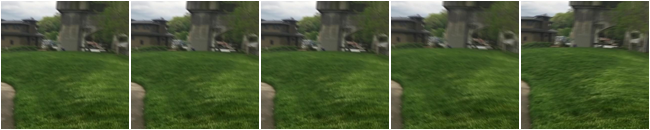

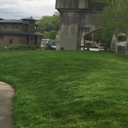

In [2]:
-- load and show first batch
require 'math'
matio = require 'matio'

function loadBatch(iVideo,iBatch)
    sampleDir = batchDirs[videoNames[iVideo]][iBatch]
    print('loading batch ' .. sampleDir)
    batchSample = matio.load(sampleDir)
    return batchSample.batchInputTorch, batchSample.batchGTTorch
end

batchInputSample,batchGTSample = loadBatch(1,1);
print(#batchInputSample)
print(#batchGTSample)


function showSampleBatch()
    print('showing patchInput')
    local patchInputSample = batchInputSample[1]
    itorch.image(patchInputSample:contiguous():view(5,3,128,128))
    
    print('showing patchGT')
    local patchGTSample = batchGTSample[1]
    itorch.image(patchGTSample)
end
showSampleBatch()

  64
  15
 128
 128
[torch.LongStorage of size 4]

  64
   3
 128
 128
[torch.LongStorage of size 4]

showing patchInput	


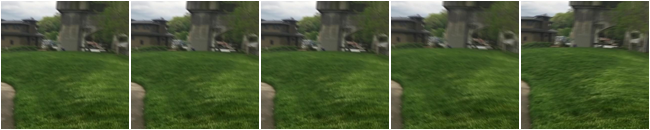

showing patchGT	


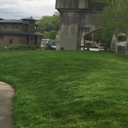

In [3]:
-- load and view random batch sample
function loadRandomBatchFrom(videoNames)
    local rBatchInputTorch = false
    local rBatchGTTorch = false
    -- some batches may got damaged?
    while true do
        local iVideo = math.random(#videoNames)
        local iBatch = math.random(#batchDirs[videoNames[iVideo]])
        local sampleDir = batchDirs[videoNames[iVideo]][iBatch]
    --     print('loading batch ' .. sampleDir)
        local batchSample = matio.load(sampleDir)
        rBatchInputTorch = batchSample.batchInputTorch
        rBatchGTTorch = batchSample.batchGTTorch
        if rBatchInputTorch and rBatchGTTorch then
            break
        end
        rBatchInputTorch = false;
        rBatchGTTorch = false;
        print(string.format('batch %s is not ok!',sampleDir))
    end
    return rBatchInputTorch, rBatchGTTorch
end

math.randomseed(251) 
batchInput,batchGT = loadRandomBatchFrom({videoNames[1]})
print(#batchInput)
print(#batchGT)

showSampleBatch()

In [4]:
package.path = package.path .. ";../models/model2_symskip_nngraph2_deeper.lua"
print(package.path)

/home/omnisky/.luarocks/share/lua/5.1/?.lua;/home/omnisky/.luarocks/share/lua/5.1/?/init.lua;/home/omnisky/torch/install/share/lua/5.1/?.lua;/home/omnisky/torch/install/share/lua/5.1/?/init.lua;./?.lua;/home/omnisky/torch/install/share/luajit-2.1.0-beta1/?.lua;/usr/local/share/lua/5.1/?.lua;/usr/local/share/lua/5.1/?/init.lua;../models/model2_symskip_nngraph2_deeper.lua	


In [5]:
-- split datasets (videoNames) into trainset and validset
local trainsetSize = 61

math.randomseed(251) 
local name2weight = {}
for iVideo,videoName in ipairs(videoNames) do
    name2weight[videoName] = math.random()
--     if iVideo<5 then
--         print(videoName,name2weight[videoName])
--     end
end
table.sort(videoNames,function(a,b) return name2weight[a]<name2weight[b] end)
trainset={}
validset={}
for iVideo,videoName in ipairs(videoNames) do
--     if iVideo<5 then
--         print(iVideo,videoName)
--     end
    if(iVideo<=trainsetSize) then
        table.insert(trainset,videoName)
    else
        table.insert(validset,videoName)
    end
end
print(string.format('Found %d trainsets and %d validsets',#trainset,#validset))

Found 61 trainsets and 10 validsets	


In [6]:
require 'torch'
require 'cunn'
require 'cutorch'
require 'nn'
require 'optim'

In [7]:
-- load model
modelDir = '../models/model2_symskip_nngraph2_deeper.lua'
require(modelDir)
net = create_model(batchInput:size(2))
net = net:cuda()

In [8]:
-- params setting
max_intensity = 255
batchSize = 48
decayFrom = 24000
decayEvery = 8000
decayRate = 0.5
itMax = 750
lossThres = 10e-6

criterion = nn.MSECriterion()
criterion = criterion:cuda()

params, gradParams = net:getParameters()
optimConfig = {
    learningRate = 0.005,
    weightDecay = 0,
    beta1 = 0.9,
    beta2 = 0.999,
    epsilon = 10e-8
}

paramsSaveDir = 'param.t7'
bn_meanvarSaveDir = 'bn_meanvar.t7'

In [15]:
-- train net
-- Log results to files
trainLogger = optim.Logger('train.log')

-- at least 12 GB video memory required for batch size 64
math.randomseed(251) 
local function  feval(params)
    gradParams:zero()
    
    local batchInputRaw,batchGTRaw = loadRandomBatchFrom(trainset)
    local shuffle = torch.randperm(batchInputRaw:size(1))
    local batchInput = torch.zeros(batchSize,batchInputRaw:size(2),batchInputRaw:size(3),batchInputRaw:size(4))
    local batchGT = torch.zeros(batchSize,batchGTRaw:size(2),batchGTRaw:size(3),batchGTRaw:size(4))
    for i=1,batchSize do
        batchInput[i] = batchInputRaw[shuffle[i]]
        batchGT[i] = batchGTRaw[shuffle[i]]
    end
    batchInput = batchInput:float():div(max_intensity):cuda()
    batchGT = batchGT:float():div(max_intensity):cuda()
        
    local predict = net:forward(batchInput)
    loss = criterion:forward(predict, batchGT)
    local dloss_dpredict = criterion:backward(predict,batchGT)
    local gradInput = net:backward(trainset, dloss_dpredict)
    
--     print(string.format('loss %f',loss))
        
    return loss, gradParams
end

local tic = sys.clock()
local time = tic;
net:training() -- set train = true
for it = 1,itMax do
    if it>=decayFrom and (it-decayFrom)%decayEvery==0 then
        optimConfig.learningRate = optimConfig.learningRate*decayRate;
    end
    optim.sgd(feval,params,optimState)
    
    local toc = sys.clock()
    timeLeft = (toc-tic)/it*(itMax-it)
    
    print(string.format(
            'it: %d, loss: %f, lr: %f, left: %.2fmin\n',
            it,loss,optimConfig.learningRate,timeLeft/60))
    
    -- update logger/plot
    trainLogger:add{['loss'] = loss}
--     trainLogger:style{['loss'] = '-'}
--     trainLogger:plot()
        
    if loss<lossThres then
        break
    end
end

it: 1, loss: 0.027019, lr: 0.005000, left: 23.86min
	


it: 2, loss: 0.033048, lr: 0.005000, left: 22.64min
	


it: 3, loss: 0.046842, lr: 0.005000, left: 29.39min
	


it: 4, loss: 0.045220, lr: 0.005000, left: 27.20min
	


it: 5, loss: 0.055947, lr: 0.005000, left: 25.45min
	


it: 6, loss: 0.039995, lr: 0.005000, left: 24.64min
	


it: 7, loss: 0.069796, lr: 0.005000, left: 24.20min
	


it: 8, loss: 0.055159, lr: 0.005000, left: 23.68min
	


it: 9, loss: 0.046104, lr: 0.005000, left: 22.98min
	


it: 10, loss: 0.052830, lr: 0.005000, left: 23.62min
	


it: 11, loss: 0.084002, lr: 0.005000, left: 23.23min
	


it: 12, loss: 0.051243, lr: 0.005000, left: 23.07min
	


it: 13, loss: 0.055482, lr: 0.005000, left: 23.10min
	


it: 14, loss: 0.077212, lr: 0.005000, left: 22.96min
	


it: 15, loss: 0.050466, lr: 0.005000, left: 22.94min
	


it: 16, loss: 0.049611, lr: 0.005000, left: 23.00min
	


it: 17, loss: 0.073224, lr: 0.005000, left: 22.86min
	


it: 18, loss: 0.038736, lr: 0.005000, left: 22.77min
	


it: 19, loss: 0.054852, lr: 0.005000, left: 26.57min
	


it: 20, loss: 0.080167, lr: 0.005000, left: 27.04min
	


it: 21, loss: 0.064406, lr: 0.005000, left: 27.19min
	


it: 22, loss: 0.044247, lr: 0.005000, left: 27.62min
	


it: 23, loss: 0.088338, lr: 0.005000, left: 27.63min
	


it: 24, loss: 0.034153, lr: 0.005000, left: 30.82min
	


it: 25, loss: 0.071148, lr: 0.005000, left: 30.56min
	


it: 26, loss: 0.032930, lr: 0.005000, left: 30.38min
	


it: 27, loss: 0.057065, lr: 0.005000, left: 30.28min
	


it: 28, loss: 0.043951, lr: 0.005000, left: 29.85min
	


it: 29, loss: 0.035013, lr: 0.005000, left: 29.49min
	


it: 30, loss: 0.065912, lr: 0.005000, left: 29.18min
	


it: 31, loss: 0.049801, lr: 0.005000, left: 28.87min
	


it: 32, loss: 0.032157, lr: 0.005000, left: 28.62min
	


it: 33, loss: 0.065495, lr: 0.005000, left: 28.34min
	


it: 34, loss: 0.051723, lr: 0.005000, left: 28.01min
	


it: 35, loss: 0.057274, lr: 0.005000, left: 27.81min
	


it: 36, loss: 0.048896, lr: 0.005000, left: 27.55min
	


it: 37, loss: 0.089531, lr: 0.005000, left: 27.38min
	


it: 38, loss: 0.034410, lr: 0.005000, left: 28.54min
	


it: 39, loss: 0.020578, lr: 0.005000, left: 28.34min
	


it: 40, loss: 0.041749, lr: 0.005000, left: 28.11min
	


it: 41, loss: 0.045716, lr: 0.005000, left: 27.84min
	


it: 42, loss: 0.042024, lr: 0.005000, left: 27.59min
	


it: 43, loss: 0.049284, lr: 0.005000, left: 27.40min
	


it: 44, loss: 0.047213, lr: 0.005000, left: 27.28min
	


it: 45, loss: 0.078107, lr: 0.005000, left: 27.22min
	


it: 46, loss: 0.098915, lr: 0.005000, left: 27.04min
	


it: 47, loss: 0.038024, lr: 0.005000, left: 26.98min
	


it: 48, loss: 0.068795, lr: 0.005000, left: 26.93min
	


it: 49, loss: 0.029115, lr: 0.005000, left: 26.88min
	


it: 50, loss: 0.034155, lr: 0.005000, left: 27.09min
	


it: 51, loss: 0.083120, lr: 0.005000, left: 27.09min
	


it: 52, loss: 0.050321, lr: 0.005000, left: 27.87min
	


it: 53, loss: 0.063888, lr: 0.005000, left: 27.85min
	


it: 54, loss: 0.044257, lr: 0.005000, left: 27.82min
	


it: 55, loss: 0.037636, lr: 0.005000, left: 27.75min
	


it: 56, loss: 0.085320, lr: 0.005000, left: 27.73min
	


it: 57, loss: 0.049347, lr: 0.005000, left: 27.67min
	


it: 58, loss: 0.054344, lr: 0.005000, left: 27.63min
	


it: 59, loss: 0.069508, lr: 0.005000, left: 27.59min
	


it: 60, loss: 0.057712, lr: 0.005000, left: 27.50min
	


it: 61, loss: 0.073860, lr: 0.005000, left: 27.66min
	


it: 62, loss: 0.066032, lr: 0.005000, left: 27.84min
	


it: 63, loss: 0.038460, lr: 0.005000, left: 27.89min
	


it: 64, loss: 0.036500, lr: 0.005000, left: 28.09min
	


it: 65, loss: 0.059911, lr: 0.005000, left: 28.36min
	


it: 66, loss: 0.051038, lr: 0.005000, left: 28.38min
	


it: 67, loss: 0.063911, lr: 0.005000, left: 28.35min
	


it: 68, loss: 0.086260, lr: 0.005000, left: 28.48min
	


it: 69, loss: 0.050957, lr: 0.005000, left: 28.53min
	


it: 70, loss: 0.062592, lr: 0.005000, left: 28.46min
	


it: 71, loss: 0.034895, lr: 0.005000, left: 28.66min
	


it: 72, loss: 0.040860, lr: 0.005000, left: 29.10min
	


it: 73, loss: 0.082953, lr: 0.005000, left: 29.11min
	


it: 74, loss: 0.066769, lr: 0.005000, left: 29.02min
	


it: 75, loss: 0.079956, lr: 0.005000, left: 28.94min
	


it: 76, loss: 0.047906, lr: 0.005000, left: 28.89min
	


it: 77, loss: 0.084934, lr: 0.005000, left: 28.85min
	


it: 78, loss: 0.057762, lr: 0.005000, left: 28.78min
	


it: 79, loss: 0.087918, lr: 0.005000, left: 28.76min
	


it: 80, loss: 0.039528, lr: 0.005000, left: 28.66min
	


it: 81, loss: 0.059569, lr: 0.005000, left: 28.69min
	


it: 82, loss: 0.034764, lr: 0.005000, left: 28.61min
	


it: 83, loss: 0.061949, lr: 0.005000, left: 29.28min
	


it: 84, loss: 0.051668, lr: 0.005000, left: 29.25min
	


it: 85, loss: 0.052408, lr: 0.005000, left: 29.16min
	


it: 86, loss: 0.056945, lr: 0.005000, left: 29.08min
	


it: 87, loss: 0.092321, lr: 0.005000, left: 29.19min
	


it: 88, loss: 0.055861, lr: 0.005000, left: 29.12min
	


it: 89, loss: 0.072156, lr: 0.005000, left: 29.32min
	


it: 90, loss: 0.028866, lr: 0.005000, left: 29.24min
	


it: 91, loss: 0.068501, lr: 0.005000, left: 29.14min
	


it: 92, loss: 0.064232, lr: 0.005000, left: 29.08min
	


it: 93, loss: 0.077806, lr: 0.005000, left: 28.97min
	


it: 94, loss: 0.040900, lr: 0.005000, left: 28.82min
	


it: 95, loss: 0.055212, lr: 0.005000, left: 28.68min
	


it: 96, loss: 0.035566, lr: 0.005000, left: 28.58min
	


it: 97, loss: 0.040998, lr: 0.005000, left: 28.44min
	


it: 98, loss: 0.058624, lr: 0.005000, left: 28.34min
	


it: 99, loss: 0.047653, lr: 0.005000, left: 28.19min
	


it: 100, loss: 0.035040, lr: 0.005000, left: 28.09min
	


it: 101, loss: 0.045483, lr: 0.005000, left: 27.99min
	


it: 102, loss: 0.056960, lr: 0.005000, left: 27.87min
	


it: 103, loss: 0.067069, lr: 0.005000, left: 28.24min
	


it: 104, loss: 0.036645, lr: 0.005000, left: 28.19min
	


it: 105, loss: 0.048870, lr: 0.005000, left: 28.08min
	


it: 106, loss: 0.063766, lr: 0.005000, left: 28.02min
	


it: 107, loss: 0.061589, lr: 0.005000, left: 27.89min
	


it: 108, loss: 0.053907, lr: 0.005000, left: 27.79min
	


it: 109, loss: 0.056531, lr: 0.005000, left: 27.77min
	


it: 110, loss: 0.042343, lr: 0.005000, left: 27.66min
	


it: 111, loss: 0.039819, lr: 0.005000, left: 27.59min
	


it: 112, loss: 0.047368, lr: 0.005000, left: 27.48min
	


it: 113, loss: 0.045487, lr: 0.005000, left: 27.44min
	


it: 114, loss: 0.081045, lr: 0.005000, left: 27.32min
	


it: 115, loss: 0.063662, lr: 0.005000, left: 27.20min
	


it: 116, loss: 0.027468, lr: 0.005000, left: 27.59min
	


it: 117, loss: 0.038191, lr: 0.005000, left: 27.51min
	


it: 118, loss: 0.043430, lr: 0.005000, left: 27.41min
	


it: 119, loss: 0.033671, lr: 0.005000, left: 27.30min
	


it: 120, loss: 0.033065, lr: 0.005000, left: 27.21min
	


it: 121, loss: 0.069179, lr: 0.005000, left: 27.09min
	


it: 122, loss: 0.079723, lr: 0.005000, left: 27.04min
	


it: 123, loss: 0.015376, lr: 0.005000, left: 26.93min
	


it: 124, loss: 0.117171, lr: 0.005000, left: 26.82min
	


it: 125, loss: 0.072970, lr: 0.005000, left: 26.72min
	


it: 126, loss: 0.047539, lr: 0.005000, left: 26.61min
	


it: 127, loss: 0.050879, lr: 0.005000, left: 26.50min
	


it: 128, loss: 0.023626, lr: 0.005000, left: 26.41min
	


it: 129, loss: 0.034915, lr: 0.005000, left: 26.31min
	


it: 130, loss: 0.062322, lr: 0.005000, left: 26.24min
	


it: 131, loss: 0.047156, lr: 0.005000, left: 26.38min
	


it: 132, loss: 0.050746, lr: 0.005000, left: 26.28min
	


it: 133, loss: 0.027092, lr: 0.005000, left: 26.19min
	


it: 134, loss: 0.043082, lr: 0.005000, left: 26.10min
	


it: 135, loss: 0.051321, lr: 0.005000, left: 26.02min
	


it: 136, loss: 0.051061, lr: 0.005000, left: 25.93min
	


it: 137, loss: 0.080572, lr: 0.005000, left: 25.86min
	


it: 138, loss: 0.063964, lr: 0.005000, left: 25.78min
	


it: 139, loss: 0.033716, lr: 0.005000, left: 25.70min
	


it: 140, loss: 0.042188, lr: 0.005000, left: 25.65min
	


it: 141, loss: 0.046746, lr: 0.005000, left: 25.58min
	


it: 142, loss: 0.040492, lr: 0.005000, left: 25.57min
	


it: 143, loss: 0.045572, lr: 0.005000, left: 25.63min
	


it: 144, loss: 0.050325, lr: 0.005000, left: 26.07min
	


it: 145, loss: 0.031007, lr: 0.005000, left: 25.98min
	


it: 146, loss: 0.035054, lr: 0.005000, left: 25.88min
	


it: 147, loss: 0.082372, lr: 0.005000, left: 25.78min
	


it: 148, loss: 0.043072, lr: 0.005000, left: 25.69min
	


it: 149, loss: 0.038792, lr: 0.005000, left: 25.57min
	


it: 150, loss: 0.078949, lr: 0.005000, left: 25.47min
	


it: 151, loss: 0.050070, lr: 0.005000, left: 25.38min
	


it: 152, loss: 0.081709, lr: 0.005000, left: 25.29min
	


it: 153, loss: 0.075820, lr: 0.005000, left: 25.20min
	


it: 154, loss: 0.032051, lr: 0.005000, left: 25.11min
	


it: 155, loss: 0.036054, lr: 0.005000, left: 25.03min
	


it: 156, loss: 0.058398, lr: 0.005000, left: 24.97min
	


it: 157, loss: 0.084977, lr: 0.005000, left: 24.88min
	


it: 158, loss: 0.042069, lr: 0.005000, left: 24.78min
	


it: 159, loss: 0.049544, lr: 0.005000, left: 24.94min
	


it: 160, loss: 0.039467, lr: 0.005000, left: 24.86min
	


it: 161, loss: 0.057221, lr: 0.005000, left: 24.79min
	


it: 162, loss: 0.089739, lr: 0.005000, left: 24.71min
	


it: 163, loss: 0.042721, lr: 0.005000, left: 24.66min
	


it: 164, loss: 0.088946, lr: 0.005000, left: 24.61min
	


it: 165, loss: 0.040958, lr: 0.005000, left: 24.56min
	


it: 166, loss: 0.047582, lr: 0.005000, left: 24.49min
	


it: 167, loss: 0.052669, lr: 0.005000, left: 24.41min
	


it: 168, loss: 0.041386, lr: 0.005000, left: 24.35min
	


it: 169, loss: 0.042405, lr: 0.005000, left: 24.26min
	


it: 170, loss: 0.036560, lr: 0.005000, left: 24.21min
	


it: 171, loss: 0.061324, lr: 0.005000, left: 24.15min
	


it: 172, loss: 0.044113, lr: 0.005000, left: 24.07min
	


it: 173, loss: 0.082613, lr: 0.005000, left: 24.21min
	


it: 174, loss: 0.029239, lr: 0.005000, left: 24.14min
	


it: 175, loss: 0.042095, lr: 0.005000, left: 24.07min
	


it: 176, loss: 0.060821, lr: 0.005000, left: 23.99min
	


it: 177, loss: 0.035300, lr: 0.005000, left: 23.94min
	


it: 178, loss: 0.042915, lr: 0.005000, left: 23.86min
	


it: 179, loss: 0.057853, lr: 0.005000, left: 23.80min
	


it: 180, loss: 0.072934, lr: 0.005000, left: 23.74min
	


it: 181, loss: 0.046591, lr: 0.005000, left: 23.68min
	


it: 182, loss: 0.050714, lr: 0.005000, left: 23.61min
	


it: 183, loss: 0.023393, lr: 0.005000, left: 23.56min
	


it: 184, loss: 0.034172, lr: 0.005000, left: 23.51min
	


it: 185, loss: 0.040942, lr: 0.005000, left: 23.46min
	


it: 186, loss: 0.034505, lr: 0.005000, left: 23.62min
	


it: 187, loss: 0.033568, lr: 0.005000, left: 23.57min
	


it: 188, loss: 0.063064, lr: 0.005000, left: 23.51min
	


it: 189, loss: 0.047384, lr: 0.005000, left: 23.47min
	


it: 190, loss: 0.047510, lr: 0.005000, left: 23.41min
	


it: 191, loss: 0.084117, lr: 0.005000, left: 23.36min
	


it: 192, loss: 0.042032, lr: 0.005000, left: 23.31min
	


it: 193, loss: 0.028047, lr: 0.005000, left: 23.26min
	


it: 194, loss: 0.035391, lr: 0.005000, left: 23.22min
	


it: 195, loss: 0.073259, lr: 0.005000, left: 23.17min
	


it: 196, loss: 0.041263, lr: 0.005000, left: 23.13min
	


it: 197, loss: 0.024214, lr: 0.005000, left: 23.09min
	


it: 198, loss: 0.048810, lr: 0.005000, left: 23.03min
	


it: 199, loss: 0.048867, lr: 0.005000, left: 23.22min
	


it: 200, loss: 0.038962, lr: 0.005000, left: 23.16min
	


it: 201, loss: 0.027474, lr: 0.005000, left: 23.09min
	


it: 202, loss: 0.030880, lr: 0.005000, left: 23.02min
	


it: 203, loss: 0.034819, lr: 0.005000, left: 22.95min
	


it: 204, loss: 0.033409, lr: 0.005000, left: 22.88min
	


it: 205, loss: 0.065498, lr: 0.005000, left: 22.81min
	


it: 206, loss: 0.048711, lr: 0.005000, left: 22.74min
	


it: 207, loss: 0.040501, lr: 0.005000, left: 22.67min
	


it: 208, loss: 0.083132, lr: 0.005000, left: 22.60min
	


it: 209, loss: 0.038831, lr: 0.005000, left: 22.54min
	


it: 210, loss: 0.030349, lr: 0.005000, left: 22.47min
	


it: 211, loss: 0.027382, lr: 0.005000, left: 22.40min
	


it: 212, loss: 0.076313, lr: 0.005000, left: 22.33min
	


it: 213, loss: 0.047322, lr: 0.005000, left: 22.42min
	


it: 214, loss: 0.032350, lr: 0.005000, left: 22.37min
	


it: 215, loss: 0.052354, lr: 0.005000, left: 22.30min
	


it: 216, loss: 0.052099, lr: 0.005000, left: 22.23min
	


it: 217, loss: 0.041870, lr: 0.005000, left: 22.17min
	


it: 218, loss: 0.048227, lr: 0.005000, left: 22.13min
	


it: 219, loss: 0.074603, lr: 0.005000, left: 22.07min
	


it: 220, loss: 0.032250, lr: 0.005000, left: 22.00min
	


it: 221, loss: 0.047143, lr: 0.005000, left: 21.94min
	


it: 222, loss: 0.084448, lr: 0.005000, left: 21.88min
	


it: 223, loss: 0.036063, lr: 0.005000, left: 21.82min
	


it: 224, loss: 0.036607, lr: 0.005000, left: 21.75min
	


it: 225, loss: 0.031853, lr: 0.005000, left: 21.69min
	


it: 226, loss: 0.036401, lr: 0.005000, left: 21.62min
	


it: 227, loss: 0.039681, lr: 0.005000, left: 21.56min
	


it: 228, loss: 0.023588, lr: 0.005000, left: 21.64min
	


it: 229, loss: 0.064108, lr: 0.005000, left: 21.62min
	


it: 230, loss: 0.062121, lr: 0.005000, left: 21.55min
	


it: 231, loss: 0.062886, lr: 0.005000, left: 21.50min
	


it: 232, loss: 0.040938, lr: 0.005000, left: 21.43min
	


it: 233, loss: 0.044098, lr: 0.005000, left: 21.36min
	


it: 234, loss: 0.040757, lr: 0.005000, left: 21.29min
	


it: 235, loss: 0.074020, lr: 0.005000, left: 21.23min
	


it: 236, loss: 0.075248, lr: 0.005000, left: 21.19min
	


it: 237, loss: 0.087086, lr: 0.005000, left: 21.13min
	


it: 238, loss: 0.086664, lr: 0.005000, left: 21.06min
	


it: 239, loss: 0.051419, lr: 0.005000, left: 21.03min
	


it: 240, loss: 0.046192, lr: 0.005000, left: 20.97min
	


it: 241, loss: 0.056486, lr: 0.005000, left: 20.95min
	


it: 242, loss: 0.053063, lr: 0.005000, left: 20.88min
	


it: 243, loss: 0.045297, lr: 0.005000, left: 20.95min
	


it: 244, loss: 0.044486, lr: 0.005000, left: 21.02min
	


it: 245, loss: 0.067608, lr: 0.005000, left: 21.00min
	


it: 246, loss: 0.061780, lr: 0.005000, left: 20.93min
	


it: 247, loss: 0.051269, lr: 0.005000, left: 20.90min
	


it: 248, loss: 0.061814, lr: 0.005000, left: 20.84min
	


it: 249, loss: 0.056616, lr: 0.005000, left: 20.80min
	


it: 250, loss: 0.039992, lr: 0.005000, left: 20.74min
	


it: 251, loss: 0.077274, lr: 0.005000, left: 20.69min
	


it: 252, loss: 0.042738, lr: 0.005000, left: 20.63min
	


it: 253, loss: 0.103484, lr: 0.005000, left: 20.57min
	


it: 254, loss: 0.062268, lr: 0.005000, left: 20.55min
	


it: 255, loss: 0.063292, lr: 0.005000, left: 20.49min
	


it: 256, loss: 0.098084, lr: 0.005000, left: 20.60min
	


it: 257, loss: 0.023969, lr: 0.005000, left: 20.54min
	


it: 258, loss: 0.047094, lr: 0.005000, left: 20.50min
	


it: 259, loss: 0.062349, lr: 0.005000, left: 20.44min
	


it: 260, loss: 0.067065, lr: 0.005000, left: 20.40min
	


it: 261, loss: 0.047697, lr: 0.005000, left: 20.36min
	


it: 262, loss: 0.055085, lr: 0.005000, left: 20.31min
	


it: 263, loss: 0.057438, lr: 0.005000, left: 20.27min
	


it: 264, loss: 0.050395, lr: 0.005000, left: 20.23min
	


it: 265, loss: 0.059823, lr: 0.005000, left: 20.18min
	


it: 266, loss: 0.068696, lr: 0.005000, left: 20.13min
	


it: 267, loss: 0.071533, lr: 0.005000, left: 20.08min
	


it: 268, loss: 0.062346, lr: 0.005000, left: 20.03min
	


it: 269, loss: 0.035229, lr: 0.005000, left: 20.09min
	


it: 270, loss: 0.053277, lr: 0.005000, left: 20.04min
	


it: 271, loss: 0.038111, lr: 0.005000, left: 20.02min
	


it: 272, loss: 0.025471, lr: 0.005000, left: 20.03min
	


it: 273, loss: 0.038636, lr: 0.005000, left: 19.99min
	


it: 274, loss: 0.034548, lr: 0.005000, left: 19.97min
	


it: 275, loss: 0.062052, lr: 0.005000, left: 19.93min
	


it: 276, loss: 0.030134, lr: 0.005000, left: 19.89min
	


it: 277, loss: 0.040695, lr: 0.005000, left: 19.85min
	


it: 278, loss: 0.033710, lr: 0.005000, left: 19.81min
	


it: 279, loss: 0.059956, lr: 0.005000, left: 19.90min
	


it: 280, loss: 0.083545, lr: 0.005000, left: 19.84min
	


it: 281, loss: 0.034183, lr: 0.005000, left: 19.79min
	


it: 282, loss: 0.052168, lr: 0.005000, left: 19.74min
	


it: 283, loss: 0.052183, lr: 0.005000, left: 19.69min
	


it: 284, loss: 0.047939, lr: 0.005000, left: 19.64min
	


it: 285, loss: 0.027596, lr: 0.005000, left: 19.60min
	


it: 286, loss: 0.062238, lr: 0.005000, left: 19.55min
	


it: 287, loss: 0.033480, lr: 0.005000, left: 19.51min
	


it: 288, loss: 0.073912, lr: 0.005000, left: 19.45min
	


it: 289, loss: 0.056050, lr: 0.005000, left: 19.40min
	


it: 290, loss: 0.052299, lr: 0.005000, left: 19.35min
	


it: 291, loss: 0.057638, lr: 0.005000, left: 19.44min
	


it: 292, loss: 0.047102, lr: 0.005000, left: 19.40min
	


it: 293, loss: 0.042720, lr: 0.005000, left: 19.35min
	


it: 294, loss: 0.051164, lr: 0.005000, left: 19.30min
	


it: 295, loss: 0.071525, lr: 0.005000, left: 19.25min
	


it: 296, loss: 0.045654, lr: 0.005000, left: 19.20min
	


it: 297, loss: 0.055614, lr: 0.005000, left: 19.14min
	


it: 298, loss: 0.069302, lr: 0.005000, left: 19.08min
	


it: 299, loss: 0.029277, lr: 0.005000, left: 19.02min
	


it: 300, loss: 0.052527, lr: 0.005000, left: 18.96min
	


it: 301, loss: 0.059382, lr: 0.005000, left: 18.91min
	


it: 302, loss: 0.060529, lr: 0.005000, left: 18.85min
	


it: 303, loss: 0.070667, lr: 0.005000, left: 18.78min
	


it: 304, loss: 0.079714, lr: 0.005000, left: 18.81min
	


it: 305, loss: 0.052281, lr: 0.005000, left: 18.78min
	


it: 306, loss: 0.022993, lr: 0.005000, left: 18.73min
	


it: 307, loss: 0.063585, lr: 0.005000, left: 18.68min
	


it: 308, loss: 0.081054, lr: 0.005000, left: 18.62min
	


it: 309, loss: 0.032401, lr: 0.005000, left: 18.56min
	


it: 310, loss: 0.072848, lr: 0.005000, left: 18.50min
	


it: 311, loss: 0.048791, lr: 0.005000, left: 18.45min
	


it: 312, loss: 0.037392, lr: 0.005000, left: 18.40min
	


it: 313, loss: 0.047916, lr: 0.005000, left: 18.35min
	


it: 314, loss: 0.048615, lr: 0.005000, left: 18.31min
	


it: 315, loss: 0.048125, lr: 0.005000, left: 18.26min
	


it: 316, loss: 0.055329, lr: 0.005000, left: 18.23min
	


it: 317, loss: 0.065048, lr: 0.005000, left: 18.20min
	


it: 318, loss: 0.046754, lr: 0.005000, left: 18.37min
	


it: 319, loss: 0.043342, lr: 0.005000, left: 18.32min
	


it: 320, loss: 0.074210, lr: 0.005000, left: 18.27min
	


it: 321, loss: 0.040002, lr: 0.005000, left: 18.22min
	


it: 322, loss: 0.069261, lr: 0.005000, left: 18.17min
	


it: 323, loss: 0.048592, lr: 0.005000, left: 18.11min
	


it: 324, loss: 0.064886, lr: 0.005000, left: 18.07min
	


it: 325, loss: 0.086417, lr: 0.005000, left: 18.02min
	


it: 326, loss: 0.073101, lr: 0.005000, left: 18.13min
	


it: 327, loss: 0.064286, lr: 0.005000, left: 18.08min
	


it: 328, loss: 0.059151, lr: 0.005000, left: 18.03min
	


it: 329, loss: 0.034474, lr: 0.005000, left: 17.98min
	


it: 330, loss: 0.075608, lr: 0.005000, left: 17.93min
	


it: 331, loss: 0.058784, lr: 0.005000, left: 17.88min
	


it: 332, loss: 0.073052, lr: 0.005000, left: 17.82min
	


it: 333, loss: 0.045716, lr: 0.005000, left: 17.77min
	


it: 334, loss: 0.068957, lr: 0.005000, left: 17.72min
	


it: 335, loss: 0.044806, lr: 0.005000, left: 17.67min
	


it: 336, loss: 0.072563, lr: 0.005000, left: 17.61min
	


it: 337, loss: 0.059324, lr: 0.005000, left: 17.55min
	


it: 338, loss: 0.054550, lr: 0.005000, left: 17.49min
	


it: 339, loss: 0.041948, lr: 0.005000, left: 17.44min
	


it: 340, loss: 0.042227, lr: 0.005000, left: 17.38min
	


it: 341, loss: 0.050744, lr: 0.005000, left: 17.33min
	


it: 342, loss: 0.023063, lr: 0.005000, left: 17.35min
	


it: 343, loss: 0.033545, lr: 0.005000, left: 17.30min
	


it: 344, loss: 0.068132, lr: 0.005000, left: 17.24min
	


it: 345, loss: 0.046400, lr: 0.005000, left: 17.19min
	


it: 346, loss: 0.062460, lr: 0.005000, left: 17.14min
	


it: 347, loss: 0.039126, lr: 0.005000, left: 17.08min
	


it: 348, loss: 0.042861, lr: 0.005000, left: 17.03min
	


it: 349, loss: 0.038159, lr: 0.005000, left: 16.98min
	


it: 350, loss: 0.067295, lr: 0.005000, left: 16.92min
	


it: 351, loss: 0.035535, lr: 0.005000, left: 16.88min
	


it: 352, loss: 0.047982, lr: 0.005000, left: 16.83min
	


it: 353, loss: 0.057129, lr: 0.005000, left: 16.78min
	


it: 354, loss: 0.062543, lr: 0.005000, left: 16.73min
	


it: 355, loss: 0.051450, lr: 0.005000, left: 16.72min
	


it: 356, loss: 0.055553, lr: 0.005000, left: 16.71min
	


it: 357, loss: 0.072716, lr: 0.005000, left: 16.67min
	


it: 358, loss: 0.059308, lr: 0.005000, left: 16.62min
	


it: 359, loss: 0.073823, lr: 0.005000, left: 16.57min
	


it: 360, loss: 0.032053, lr: 0.005000, left: 16.53min
	


it: 361, loss: 0.066138, lr: 0.005000, left: 16.48min
	


it: 362, loss: 0.045513, lr: 0.005000, left: 16.43min
	


it: 363, loss: 0.081640, lr: 0.005000, left: 16.38min
	


it: 364, loss: 0.052113, lr: 0.005000, left: 16.33min
	


it: 365, loss: 0.059490, lr: 0.005000, left: 16.28min
	


it: 366, loss: 0.029438, lr: 0.005000, left: 16.23min
	


it: 367, loss: 0.045488, lr: 0.005000, left: 16.18min
	


it: 368, loss: 0.060735, lr: 0.005000, left: 16.15min
	


it: 369, loss: 0.036865, lr: 0.005000, left: 16.09min
	


it: 370, loss: 0.047544, lr: 0.005000, left: 16.04min
	


it: 371, loss: 0.024075, lr: 0.005000, left: 15.99min
	


it: 372, loss: 0.044683, lr: 0.005000, left: 15.93min
	


it: 373, loss: 0.043324, lr: 0.005000, left: 15.88min
	


it: 374, loss: 0.039912, lr: 0.005000, left: 15.83min
	


it: 375, loss: 0.031827, lr: 0.005000, left: 15.77min
	


it: 376, loss: 0.071589, lr: 0.005000, left: 15.72min
	


it: 377, loss: 0.076384, lr: 0.005000, left: 15.67min
	


it: 378, loss: 0.060873, lr: 0.005000, left: 15.62min
	


it: 379, loss: 0.071043, lr: 0.005000, left: 15.56min
	


it: 380, loss: 0.040493, lr: 0.005000, left: 15.51min
	


it: 381, loss: 0.042458, lr: 0.005000, left: 15.46min
	


it: 382, loss: 0.034584, lr: 0.005000, left: 15.41min
	


it: 383, loss: 0.076815, lr: 0.005000, left: 15.35min
	


it: 384, loss: 0.082039, lr: 0.005000, left: 15.31min
	


it: 385, loss: 0.048124, lr: 0.005000, left: 15.26min
	


it: 386, loss: 0.053661, lr: 0.005000, left: 15.21min
	


it: 387, loss: 0.026324, lr: 0.005000, left: 15.16min
	


it: 388, loss: 0.049479, lr: 0.005000, left: 15.11min
	


it: 389, loss: 0.059130, lr: 0.005000, left: 15.07min
	


it: 390, loss: 0.053543, lr: 0.005000, left: 15.02min
	


it: 391, loss: 0.101736, lr: 0.005000, left: 14.98min
	


it: 392, loss: 0.017805, lr: 0.005000, left: 14.93min
	


it: 393, loss: 0.045376, lr: 0.005000, left: 14.87min
	


it: 394, loss: 0.047522, lr: 0.005000, left: 14.82min
	


it: 395, loss: 0.039503, lr: 0.005000, left: 14.77min
	


it: 396, loss: 0.031568, lr: 0.005000, left: 14.73min
	


it: 397, loss: 0.078778, lr: 0.005000, left: 14.68min
	


it: 398, loss: 0.035368, lr: 0.005000, left: 14.63min
	


it: 399, loss: 0.072529, lr: 0.005000, left: 14.57min
	


it: 400, loss: 0.028406, lr: 0.005000, left: 14.53min
	


it: 401, loss: 0.038924, lr: 0.005000, left: 14.48min
	


it: 402, loss: 0.031377, lr: 0.005000, left: 14.43min
	


it: 403, loss: 0.042661, lr: 0.005000, left: 14.38min
	


it: 404, loss: 0.047647, lr: 0.005000, left: 14.33min
	


it: 405, loss: 0.037300, lr: 0.005000, left: 14.28min
	


it: 406, loss: 0.046582, lr: 0.005000, left: 14.22min
	


it: 407, loss: 0.043190, lr: 0.005000, left: 14.18min
	


it: 408, loss: 0.076286, lr: 0.005000, left: 14.13min
	


it: 409, loss: 0.064377, lr: 0.005000, left: 14.08min
	


it: 410, loss: 0.044226, lr: 0.005000, left: 14.03min
	


it: 411, loss: 0.069850, lr: 0.005000, left: 13.98min
	


it: 412, loss: 0.063379, lr: 0.005000, left: 13.93min
	


it: 413, loss: 0.038235, lr: 0.005000, left: 13.88min
	


it: 414, loss: 0.049931, lr: 0.005000, left: 13.83min
	


it: 415, loss: 0.075705, lr: 0.005000, left: 13.78min
	


it: 416, loss: 0.068687, lr: 0.005000, left: 13.73min
	


it: 417, loss: 0.048424, lr: 0.005000, left: 13.69min
	


it: 418, loss: 0.073607, lr: 0.005000, left: 13.64min
	


it: 419, loss: 0.044013, lr: 0.005000, left: 13.60min
	


it: 420, loss: 0.053880, lr: 0.005000, left: 13.55min
	


it: 421, loss: 0.052427, lr: 0.005000, left: 13.51min
	


it: 422, loss: 0.050166, lr: 0.005000, left: 13.47min
	


it: 423, loss: 0.078646, lr: 0.005000, left: 13.42min
	


it: 424, loss: 0.061123, lr: 0.005000, left: 13.40min
	


it: 425, loss: 0.035809, lr: 0.005000, left: 13.36min
	


it: 426, loss: 0.041411, lr: 0.005000, left: 13.32min
	


it: 427, loss: 0.038998, lr: 0.005000, left: 13.28min
	


it: 428, loss: 0.049605, lr: 0.005000, left: 13.23min
	


it: 429, loss: 0.061806, lr: 0.005000, left: 13.19min
	


it: 430, loss: 0.056680, lr: 0.005000, left: 13.16min
	


it: 431, loss: 0.044098, lr: 0.005000, left: 13.11min
	


it: 432, loss: 0.053120, lr: 0.005000, left: 13.08min
	


it: 433, loss: 0.069087, lr: 0.005000, left: 13.03min
	


it: 434, loss: 0.036163, lr: 0.005000, left: 12.99min
	


it: 435, loss: 0.026687, lr: 0.005000, left: 12.94min
	


it: 436, loss: 0.068027, lr: 0.005000, left: 12.90min
	


it: 437, loss: 0.027321, lr: 0.005000, left: 12.85min
	


it: 438, loss: 0.035659, lr: 0.005000, left: 12.81min
	


it: 439, loss: 0.065366, lr: 0.005000, left: 12.76min
	


it: 440, loss: 0.049814, lr: 0.005000, left: 12.72min
	


it: 441, loss: 0.054417, lr: 0.005000, left: 12.68min
	


it: 442, loss: 0.046658, lr: 0.005000, left: 12.63min
	


it: 443, loss: 0.076269, lr: 0.005000, left: 12.59min
	


it: 444, loss: 0.057730, lr: 0.005000, left: 12.55min
	


it: 445, loss: 0.026358, lr: 0.005000, left: 12.51min
	


it: 446, loss: 0.023096, lr: 0.005000, left: 12.47min
	


it: 447, loss: 0.076193, lr: 0.005000, left: 12.42min
	


it: 448, loss: 0.072383, lr: 0.005000, left: 12.37min
	


it: 449, loss: 0.049294, lr: 0.005000, left: 12.33min
	


it: 450, loss: 0.067800, lr: 0.005000, left: 12.28min
	


it: 451, loss: 0.068300, lr: 0.005000, left: 12.24min
	


it: 452, loss: 0.055066, lr: 0.005000, left: 12.19min
	


it: 453, loss: 0.045259, lr: 0.005000, left: 12.14min
	


it: 454, loss: 0.070197, lr: 0.005000, left: 12.09min
	


it: 455, loss: 0.072519, lr: 0.005000, left: 12.05min
	


it: 456, loss: 0.077000, lr: 0.005000, left: 12.01min
	


it: 457, loss: 0.032265, lr: 0.005000, left: 11.96min
	


it: 458, loss: 0.065322, lr: 0.005000, left: 11.91min
	


it: 459, loss: 0.061438, lr: 0.005000, left: 11.87min
	


it: 460, loss: 0.043484, lr: 0.005000, left: 11.82min
	


it: 461, loss: 0.046949, lr: 0.005000, left: 11.78min
	


it: 462, loss: 0.065084, lr: 0.005000, left: 11.73min
	


it: 463, loss: 0.064485, lr: 0.005000, left: 11.68min
	


it: 464, loss: 0.047263, lr: 0.005000, left: 11.64min
	


it: 465, loss: 0.030011, lr: 0.005000, left: 11.60min
	


it: 466, loss: 0.056109, lr: 0.005000, left: 11.55min
	


it: 467, loss: 0.065281, lr: 0.005000, left: 11.50min
	


it: 468, loss: 0.049666, lr: 0.005000, left: 11.47min
	


it: 469, loss: 0.076691, lr: 0.005000, left: 11.42min
	


it: 470, loss: 0.058506, lr: 0.005000, left: 11.37min
	


it: 471, loss: 0.048328, lr: 0.005000, left: 11.33min
	


it: 472, loss: 0.038330, lr: 0.005000, left: 11.28min
	


it: 473, loss: 0.062250, lr: 0.005000, left: 11.24min
	


it: 474, loss: 0.077467, lr: 0.005000, left: 11.20min
	


it: 475, loss: 0.074911, lr: 0.005000, left: 11.15min
	


it: 476, loss: 0.044466, lr: 0.005000, left: 11.11min
	


it: 477, loss: 0.032652, lr: 0.005000, left: 11.06min
	


it: 478, loss: 0.045455, lr: 0.005000, left: 11.02min
	


it: 479, loss: 0.039644, lr: 0.005000, left: 10.97min
	


it: 480, loss: 0.043487, lr: 0.005000, left: 10.92min
	


it: 481, loss: 0.041082, lr: 0.005000, left: 10.88min
	


it: 482, loss: 0.061871, lr: 0.005000, left: 10.83min
	


it: 483, loss: 0.031721, lr: 0.005000, left: 10.79min
	


it: 484, loss: 0.052721, lr: 0.005000, left: 10.74min
	


it: 485, loss: 0.046048, lr: 0.005000, left: 10.70min
	


it: 486, loss: 0.068694, lr: 0.005000, left: 10.65min
	


it: 487, loss: 0.039322, lr: 0.005000, left: 10.61min
	


it: 488, loss: 0.043026, lr: 0.005000, left: 10.56min
	


it: 489, loss: 0.047243, lr: 0.005000, left: 10.52min
	


it: 490, loss: 0.052049, lr: 0.005000, left: 10.47min
	


it: 491, loss: 0.072587, lr: 0.005000, left: 10.44min
	


it: 492, loss: 0.076362, lr: 0.005000, left: 10.40min
	


it: 493, loss: 0.076820, lr: 0.005000, left: 10.35min
	


it: 494, loss: 0.045690, lr: 0.005000, left: 10.31min
	


it: 495, loss: 0.040774, lr: 0.005000, left: 10.27min
	


it: 496, loss: 0.046281, lr: 0.005000, left: 10.22min
	


it: 497, loss: 0.059921, lr: 0.005000, left: 10.18min
	


it: 498, loss: 0.033611, lr: 0.005000, left: 10.14min
	


it: 499, loss: 0.026455, lr: 0.005000, left: 10.09min
	


it: 500, loss: 0.049727, lr: 0.005000, left: 10.04min
	


it: 501, loss: 0.061317, lr: 0.005000, left: 10.00min
	


it: 502, loss: 0.045380, lr: 0.005000, left: 9.95min
	


it: 503, loss: 0.052045, lr: 0.005000, left: 9.91min
	


it: 504, loss: 0.060133, lr: 0.005000, left: 9.86min
	


it: 505, loss: 0.058946, lr: 0.005000, left: 9.82min
	


it: 506, loss: 0.034834, lr: 0.005000, left: 9.78min
	


it: 507, loss: 0.063694, lr: 0.005000, left: 9.73min
	


it: 508, loss: 0.030924, lr: 0.005000, left: 9.69min
	


it: 509, loss: 0.030716, lr: 0.005000, left: 9.65min
	


it: 510, loss: 0.069152, lr: 0.005000, left: 9.60min
	


it: 511, loss: 0.058148, lr: 0.005000, left: 9.56min
	


it: 512, loss: 0.054303, lr: 0.005000, left: 9.52min
	


it: 513, loss: 0.060436, lr: 0.005000, left: 9.47min
	


it: 514, loss: 0.036671, lr: 0.005000, left: 9.43min
	


it: 515, loss: 0.040928, lr: 0.005000, left: 9.38min
	


it: 516, loss: 0.050490, lr: 0.005000, left: 9.34min
	


it: 517, loss: 0.040127, lr: 0.005000, left: 9.30min
	


it: 518, loss: 0.058031, lr: 0.005000, left: 9.26min
	


it: 519, loss: 0.043894, lr: 0.005000, left: 9.21min
	


it: 520, loss: 0.046937, lr: 0.005000, left: 9.17min
	


it: 521, loss: 0.044621, lr: 0.005000, left: 9.12min
	


it: 522, loss: 0.028766, lr: 0.005000, left: 9.08min
	


it: 523, loss: 0.052205, lr: 0.005000, left: 9.04min
	


it: 524, loss: 0.059705, lr: 0.005000, left: 9.00min
	


it: 525, loss: 0.034397, lr: 0.005000, left: 8.95min
	


it: 526, loss: 0.086206, lr: 0.005000, left: 8.91min
	


it: 527, loss: 0.051406, lr: 0.005000, left: 8.87min
	


it: 528, loss: 0.071888, lr: 0.005000, left: 8.83min
	


it: 529, loss: 0.071156, lr: 0.005000, left: 8.79min
	


it: 530, loss: 0.025711, lr: 0.005000, left: 8.75min
	


it: 531, loss: 0.064296, lr: 0.005000, left: 8.71min
	


it: 532, loss: 0.056471, lr: 0.005000, left: 8.66min
	


it: 533, loss: 0.047053, lr: 0.005000, left: 8.62min
	


it: 534, loss: 0.069908, lr: 0.005000, left: 8.58min
	


it: 535, loss: 0.057852, lr: 0.005000, left: 8.54min
	


it: 536, loss: 0.049182, lr: 0.005000, left: 8.50min
	


it: 537, loss: 0.040186, lr: 0.005000, left: 8.46min
	


it: 538, loss: 0.055855, lr: 0.005000, left: 8.42min
	


it: 539, loss: 0.047002, lr: 0.005000, left: 8.38min
	


it: 540, loss: 0.030020, lr: 0.005000, left: 8.33min
	


it: 541, loss: 0.060574, lr: 0.005000, left: 8.29min
	


it: 542, loss: 0.031557, lr: 0.005000, left: 8.25min
	


it: 543, loss: 0.022406, lr: 0.005000, left: 8.21min
	


it: 544, loss: 0.035603, lr: 0.005000, left: 8.17min
	


it: 545, loss: 0.039047, lr: 0.005000, left: 8.13min
	


it: 546, loss: 0.026304, lr: 0.005000, left: 8.09min
	


it: 547, loss: 0.039757, lr: 0.005000, left: 8.05min
	


it: 548, loss: 0.074474, lr: 0.005000, left: 8.01min
	


it: 549, loss: 0.063281, lr: 0.005000, left: 7.97min
	


it: 550, loss: 0.042670, lr: 0.005000, left: 7.93min
	


it: 551, loss: 0.037813, lr: 0.005000, left: 7.89min
	


it: 552, loss: 0.036134, lr: 0.005000, left: 7.85min
	


it: 553, loss: 0.080019, lr: 0.005000, left: 7.81min
	


it: 554, loss: 0.028156, lr: 0.005000, left: 7.76min
	


it: 555, loss: 0.032851, lr: 0.005000, left: 7.72min
	


it: 556, loss: 0.042164, lr: 0.005000, left: 7.68min
	


it: 557, loss: 0.038484, lr: 0.005000, left: 7.64min
	


it: 558, loss: 0.085958, lr: 0.005000, left: 7.60min
	


it: 559, loss: 0.049374, lr: 0.005000, left: 7.55min
	


it: 560, loss: 0.032816, lr: 0.005000, left: 7.52min
	


it: 561, loss: 0.043717, lr: 0.005000, left: 7.48min
	


it: 562, loss: 0.048042, lr: 0.005000, left: 7.43min
	


it: 563, loss: 0.051796, lr: 0.005000, left: 7.39min
	


it: 564, loss: 0.046979, lr: 0.005000, left: 7.35min
	


it: 565, loss: 0.045993, lr: 0.005000, left: 7.31min
	


it: 566, loss: 0.035843, lr: 0.005000, left: 7.26min
	


it: 567, loss: 0.046532, lr: 0.005000, left: 7.22min
	


it: 568, loss: 0.058027, lr: 0.005000, left: 7.18min
	


it: 569, loss: 0.038933, lr: 0.005000, left: 7.14min
	


it: 570, loss: 0.045018, lr: 0.005000, left: 7.10min
	


it: 571, loss: 0.072010, lr: 0.005000, left: 7.06min
	


it: 572, loss: 0.067849, lr: 0.005000, left: 7.01min
	


it: 573, loss: 0.031840, lr: 0.005000, left: 6.97min
	


it: 574, loss: 0.063373, lr: 0.005000, left: 6.93min
	


it: 575, loss: 0.038828, lr: 0.005000, left: 6.89min
	


it: 576, loss: 0.081553, lr: 0.005000, left: 6.85min
	


it: 577, loss: 0.043554, lr: 0.005000, left: 6.81min
	


it: 578, loss: 0.075458, lr: 0.005000, left: 6.77min
	


it: 579, loss: 0.059433, lr: 0.005000, left: 6.73min
	


it: 580, loss: 0.063353, lr: 0.005000, left: 6.69min
	


it: 581, loss: 0.058333, lr: 0.005000, left: 6.65min
	


it: 582, loss: 0.069007, lr: 0.005000, left: 6.61min
	


it: 583, loss: 0.055833, lr: 0.005000, left: 6.57min
	


it: 584, loss: 0.031010, lr: 0.005000, left: 6.53min
	


it: 585, loss: 0.046051, lr: 0.005000, left: 6.49min
	


it: 586, loss: 0.025453, lr: 0.005000, left: 6.45min
	


it: 587, loss: 0.044908, lr: 0.005000, left: 6.41min
	


it: 588, loss: 0.073804, lr: 0.005000, left: 6.37min
	


it: 589, loss: 0.037873, lr: 0.005000, left: 6.34min
	


it: 590, loss: 0.027343, lr: 0.005000, left: 6.29min
	


it: 591, loss: 0.071460, lr: 0.005000, left: 6.25min
	


it: 592, loss: 0.060520, lr: 0.005000, left: 6.21min
	


it: 593, loss: 0.043793, lr: 0.005000, left: 6.17min
	


it: 594, loss: 0.043942, lr: 0.005000, left: 6.13min
	


it: 595, loss: 0.035174, lr: 0.005000, left: 6.09min
	


it: 596, loss: 0.019464, lr: 0.005000, left: 6.05min
	


it: 597, loss: 0.077023, lr: 0.005000, left: 6.01min
	


it: 598, loss: 0.035152, lr: 0.005000, left: 5.97min
	


it: 599, loss: 0.072340, lr: 0.005000, left: 5.93min
	


it: 600, loss: 0.047091, lr: 0.005000, left: 5.89min
	


it: 601, loss: 0.048592, lr: 0.005000, left: 5.85min
	


it: 602, loss: 0.049184, lr: 0.005000, left: 5.81min
	


it: 603, loss: 0.031967, lr: 0.005000, left: 5.77min
	


it: 604, loss: 0.064198, lr: 0.005000, left: 5.72min
	


it: 605, loss: 0.051507, lr: 0.005000, left: 5.68min
	


it: 606, loss: 0.044483, lr: 0.005000, left: 5.64min
	


it: 607, loss: 0.070797, lr: 0.005000, left: 5.60min
	


it: 608, loss: 0.045279, lr: 0.005000, left: 5.56min
	


it: 609, loss: 0.049285, lr: 0.005000, left: 5.52min
	


it: 610, loss: 0.076375, lr: 0.005000, left: 5.48min
	


it: 611, loss: 0.046655, lr: 0.005000, left: 5.44min
	


it: 612, loss: 0.053905, lr: 0.005000, left: 5.40min
	


it: 613, loss: 0.043761, lr: 0.005000, left: 5.36min
	


it: 614, loss: 0.052109, lr: 0.005000, left: 5.32min
	


it: 615, loss: 0.063402, lr: 0.005000, left: 5.28min
	


it: 616, loss: 0.048918, lr: 0.005000, left: 5.24min
	


it: 617, loss: 0.049449, lr: 0.005000, left: 5.20min
	


it: 618, loss: 0.027052, lr: 0.005000, left: 5.15min
	


it: 619, loss: 0.048417, lr: 0.005000, left: 5.11min
	


it: 620, loss: 0.020258, lr: 0.005000, left: 5.07min
	


it: 621, loss: 0.072503, lr: 0.005000, left: 5.03min
	


it: 622, loss: 0.040785, lr: 0.005000, left: 4.99min
	


it: 623, loss: 0.052367, lr: 0.005000, left: 4.95min
	


it: 624, loss: 0.040006, lr: 0.005000, left: 4.92min
	


it: 625, loss: 0.037458, lr: 0.005000, left: 4.88min
	


it: 626, loss: 0.082865, lr: 0.005000, left: 4.84min
	


it: 627, loss: 0.048230, lr: 0.005000, left: 4.80min
	


it: 628, loss: 0.066557, lr: 0.005000, left: 4.76min
	


it: 629, loss: 0.086941, lr: 0.005000, left: 4.72min
	


it: 630, loss: 0.051042, lr: 0.005000, left: 4.68min
	


it: 631, loss: 0.050287, lr: 0.005000, left: 4.64min
	


it: 632, loss: 0.079813, lr: 0.005000, left: 4.60min
	


it: 633, loss: 0.032047, lr: 0.005000, left: 4.56min
	


it: 634, loss: 0.043454, lr: 0.005000, left: 4.52min
	


it: 635, loss: 0.110446, lr: 0.005000, left: 4.48min
	


it: 636, loss: 0.049879, lr: 0.005000, left: 4.44min
	


it: 637, loss: 0.045063, lr: 0.005000, left: 4.40min
	


it: 638, loss: 0.038066, lr: 0.005000, left: 4.36min
	


it: 639, loss: 0.042217, lr: 0.005000, left: 4.32min
	


it: 640, loss: 0.059229, lr: 0.005000, left: 4.28min
	


it: 641, loss: 0.060791, lr: 0.005000, left: 4.24min
	


it: 642, loss: 0.044828, lr: 0.005000, left: 4.20min
	


it: 643, loss: 0.048991, lr: 0.005000, left: 4.17min
	


it: 644, loss: 0.064092, lr: 0.005000, left: 4.13min
	


it: 645, loss: 0.038555, lr: 0.005000, left: 4.09min
	


it: 646, loss: 0.039656, lr: 0.005000, left: 4.05min
	


it: 647, loss: 0.052273, lr: 0.005000, left: 4.01min
	


it: 648, loss: 0.052027, lr: 0.005000, left: 3.97min
	


it: 649, loss: 0.029645, lr: 0.005000, left: 3.93min
	


it: 650, loss: 0.030738, lr: 0.005000, left: 3.89min
	


it: 651, loss: 0.062567, lr: 0.005000, left: 3.85min
	


it: 652, loss: 0.049151, lr: 0.005000, left: 3.81min
	


it: 653, loss: 0.068326, lr: 0.005000, left: 3.77min
	


it: 654, loss: 0.051346, lr: 0.005000, left: 3.73min
	


it: 655, loss: 0.059280, lr: 0.005000, left: 3.69min
	


it: 656, loss: 0.028620, lr: 0.005000, left: 3.65min
	


it: 657, loss: 0.074253, lr: 0.005000, left: 3.61min
	


it: 658, loss: 0.047447, lr: 0.005000, left: 3.57min
	


it: 659, loss: 0.050857, lr: 0.005000, left: 3.53min
	


it: 660, loss: 0.060652, lr: 0.005000, left: 3.49min
	


it: 661, loss: 0.047651, lr: 0.005000, left: 3.45min
	


it: 662, loss: 0.057497, lr: 0.005000, left: 3.41min
	


it: 663, loss: 0.025213, lr: 0.005000, left: 3.38min
	


it: 664, loss: 0.067584, lr: 0.005000, left: 3.34min
	


it: 665, loss: 0.054260, lr: 0.005000, left: 3.30min
	


it: 666, loss: 0.076109, lr: 0.005000, left: 3.26min
	


it: 667, loss: 0.048437, lr: 0.005000, left: 3.22min
	


it: 668, loss: 0.047277, lr: 0.005000, left: 3.18min
	


it: 669, loss: 0.048631, lr: 0.005000, left: 3.14min
	


it: 670, loss: 0.065180, lr: 0.005000, left: 3.10min
	


it: 671, loss: 0.034684, lr: 0.005000, left: 3.06min
	


it: 672, loss: 0.048082, lr: 0.005000, left: 3.02min
	


it: 673, loss: 0.086069, lr: 0.005000, left: 2.98min
	


it: 674, loss: 0.071875, lr: 0.005000, left: 2.94min
	


it: 675, loss: 0.035692, lr: 0.005000, left: 2.90min
	


it: 676, loss: 0.032636, lr: 0.005000, left: 2.86min
	


it: 677, loss: 0.032192, lr: 0.005000, left: 2.82min
	


it: 678, loss: 0.055725, lr: 0.005000, left: 2.78min
	


it: 679, loss: 0.057465, lr: 0.005000, left: 2.74min
	


it: 680, loss: 0.066902, lr: 0.005000, left: 2.70min
	


it: 681, loss: 0.048122, lr: 0.005000, left: 2.67min
	


it: 682, loss: 0.065592, lr: 0.005000, left: 2.63min
	


it: 683, loss: 0.054420, lr: 0.005000, left: 2.59min
	


it: 684, loss: 0.054070, lr: 0.005000, left: 2.55min
	


it: 685, loss: 0.040792, lr: 0.005000, left: 2.51min
	


it: 686, loss: 0.077321, lr: 0.005000, left: 2.47min
	


it: 687, loss: 0.072186, lr: 0.005000, left: 2.44min
	


it: 688, loss: 0.045058, lr: 0.005000, left: 2.40min
	


it: 689, loss: 0.045895, lr: 0.005000, left: 2.36min
	


it: 690, loss: 0.046080, lr: 0.005000, left: 2.32min
	


it: 691, loss: 0.052540, lr: 0.005000, left: 2.28min
	


it: 692, loss: 0.051544, lr: 0.005000, left: 2.25min
	


it: 693, loss: 0.062818, lr: 0.005000, left: 2.21min
	


it: 694, loss: 0.069008, lr: 0.005000, left: 2.17min
	


it: 695, loss: 0.080033, lr: 0.005000, left: 2.13min
	


it: 696, loss: 0.036680, lr: 0.005000, left: 2.09min
	


it: 697, loss: 0.033922, lr: 0.005000, left: 2.05min
	


it: 698, loss: 0.030995, lr: 0.005000, left: 2.01min
	


it: 699, loss: 0.060350, lr: 0.005000, left: 1.98min
	


it: 700, loss: 0.052403, lr: 0.005000, left: 1.94min
	


it: 701, loss: 0.033972, lr: 0.005000, left: 1.90min
	


it: 702, loss: 0.030756, lr: 0.005000, left: 1.86min
	


it: 703, loss: 0.068451, lr: 0.005000, left: 1.82min
	


it: 704, loss: 0.035288, lr: 0.005000, left: 1.79min
	


it: 705, loss: 0.037419, lr: 0.005000, left: 1.75min
	


it: 706, loss: 0.041678, lr: 0.005000, left: 1.71min
	


it: 707, loss: 0.038158, lr: 0.005000, left: 1.67min
	


it: 708, loss: 0.073629, lr: 0.005000, left: 1.63min
	


it: 709, loss: 0.053345, lr: 0.005000, left: 1.60min
	


it: 710, loss: 0.062720, lr: 0.005000, left: 1.56min
	


it: 711, loss: 0.076630, lr: 0.005000, left: 1.52min
	


it: 712, loss: 0.062464, lr: 0.005000, left: 1.48min
	


it: 713, loss: 0.072767, lr: 0.005000, left: 1.44min
	


it: 714, loss: 0.034466, lr: 0.005000, left: 1.41min
	


it: 715, loss: 0.029842, lr: 0.005000, left: 1.37min
	


it: 716, loss: 0.039534, lr: 0.005000, left: 1.33min
	


it: 717, loss: 0.043602, lr: 0.005000, left: 1.29min
	


it: 718, loss: 0.053351, lr: 0.005000, left: 1.26min
	


it: 719, loss: 0.033542, lr: 0.005000, left: 1.22min
	


it: 720, loss: 0.044718, lr: 0.005000, left: 1.18min
	


it: 721, loss: 0.063271, lr: 0.005000, left: 1.14min
	


it: 722, loss: 0.060470, lr: 0.005000, left: 1.11min
	


it: 723, loss: 0.066230, lr: 0.005000, left: 1.07min
	


it: 724, loss: 0.026936, lr: 0.005000, left: 1.03min
	


it: 725, loss: 0.032951, lr: 0.005000, left: 0.99min
	


it: 726, loss: 0.076751, lr: 0.005000, left: 0.95min
	


it: 727, loss: 0.059484, lr: 0.005000, left: 0.91min
	


it: 728, loss: 0.062678, lr: 0.005000, left: 0.87min
	


it: 729, loss: 0.043849, lr: 0.005000, left: 0.83min
	


it: 730, loss: 0.027003, lr: 0.005000, left: 0.79min
	


it: 731, loss: 0.067689, lr: 0.005000, left: 0.76min
	


it: 732, loss: 0.066098, lr: 0.005000, left: 0.72min
	


it: 733, loss: 0.037826, lr: 0.005000, left: 0.68min
	


it: 734, loss: 0.074980, lr: 0.005000, left: 0.64min
	


it: 735, loss: 0.076427, lr: 0.005000, left: 0.60min
	


it: 736, loss: 0.044826, lr: 0.005000, left: 0.56min
	


it: 737, loss: 0.041873, lr: 0.005000, left: 0.52min
	


it: 738, loss: 0.072160, lr: 0.005000, left: 0.48min
	


it: 739, loss: 0.080467, lr: 0.005000, left: 0.44min
	


it: 740, loss: 0.066594, lr: 0.005000, left: 0.40min
	


it: 741, loss: 0.068619, lr: 0.005000, left: 0.36min
	


it: 742, loss: 0.065502, lr: 0.005000, left: 0.32min
	


it: 743, loss: 0.056138, lr: 0.005000, left: 0.28min
	


it: 744, loss: 0.048617, lr: 0.005000, left: 0.24min
	


it: 745, loss: 0.039424, lr: 0.005000, left: 0.20min
	


it: 746, loss: 0.034475, lr: 0.005000, left: 0.16min
	


it: 747, loss: 0.040885, lr: 0.005000, left: 0.12min
	


it: 748, loss: 0.047028, lr: 0.005000, left: 0.08min
	


it: 749, loss: 0.040822, lr: 0.005000, left: 0.04min
	


batch /media/omnisky/35e132dd-effd-42c8-abe8-8038007fc01d/zc/DeepVideoDeblurring/data/training_augumented_all_nostab_nowarp/IMG_0054/batch_width128_size64_28590.mat is not ok!	


it: 750, loss: 0.044703, lr: 0.005000, left: 0.00min
	


In [ ]:
-- save params
torch.save(paramsSaveDir,params)
local bn_mean = {}
local bn_std = {}
for k,v in pairs(net:findModules('nn.SpatialBatchNormalization')) do
    table.insert(bn_mean,v.running_mean)
    table.insert(bn_std,v.running_var)
end
local bn_meanvar = {bn_mean,bn_std}
torch.save(bn_meanvarSaveDir,bn_meanvar)

In [9]:
-- load params

bn_meanvarSaveDir = '../logs/1029_model2_symskip_nngraph2_deeper_nowarp/bn_meanvar_epoch_400iteration_4000.t7'
paramsSaveDir = '../logs/1029_model2_symskip_nngraph2_deeper_nowarp/param_epoch_400iteration_4000.t7'-- comment to test params saved above

local paramsSave = torch.load(paramsSaveDir)
local bn_meanvarSave = torch.load(bn_meanvarSaveDir)

params:copy(paramsSave)
local bn_mean, bn_std = table.unpack(bn_meanvarSave)
for k,v in pairs(net:findModules('nn.SpatialBatchNormalization')) do
    v.running_mean:copy(bn_mean[k])
    v.running_var:copy(bn_std[k])
end

In [10]:
-- test net

-- load batch
function loadBatch(videoNames,iBatch)
    local sampleDir = batchDirs[videoNames][iBatch]
--     print('loading batch ' .. sampleDir)
    local batchSample = matio.load(sampleDir)
    return batchSample.batchInputTorch, batchSample.batchGTTorch
end

local lossTrainset = 0
local nPatches = 0
local nPatchesEveryMax = 1

net:evaluate() -- set train = false
for iVideo,videoName in ipairs(trainset) do
--     for iBatch = 1,#batchDirs[videoName] do
    for iBatch = 1,nPatchesEveryMax do
        local batchInput,batchGT = loadBatch(videoName,iBatch)
        batchInput = batchInput[{{1,batchSize},{},{},{}}] -- out of memory!?
        batchGT = batchGT[{{1,batchSize},{},{},{}}]
        batchInput = batchInput:float():div(max_intensity):cuda()
        batchGT = batchGT:float():div(max_intensity):cuda()

        local predict = net:forward(batchInput)
        lossTrainset = lossTrainset+criterion:forward(predict, batchGT)
        nPatches = nPatches+1
        print(string.format('%d patches done',nPatches))
    end
end
lossTrainset = lossTrainset/nPatches
print(string.format('final train loss: %f',lossTrainset))

1 patches done	


2 patches done	


3 patches done	


4 patches done	


5 patches done	


6 patches done	


7 patches done	


8 patches done	


9 patches done	


10 patches done	


11 patches done	


12 patches done	


13 patches done	


14 patches done	


15 patches done	


16 patches done	


17 patches done	


18 patches done	


19 patches done	


20 patches done	


21 patches done	


22 patches done	


23 patches done	


24 patches done	


25 patches done	


26 patches done	


27 patches done	


28 patches done	


29 patches done	


30 patches done	


31 patches done	


32 patches done	


33 patches done	


34 patches done	


35 patches done	


36 patches done	


37 patches done	


38 patches done	


39 patches done	


40 patches done	


41 patches done	


42 patches done	


43 patches done	


44 patches done	


45 patches done	


46 patches done	


47 patches done	


48 patches done	


49 patches done	


50 patches done	


51 patches done	


52 patches done	


53 patches done	


54 patches done	


55 patches done	


56 patches done	


57 patches done	


58 patches done	


59 patches done	


60 patches done	


61 patches done	
final train loss: 0.027021	


showing patchInput	


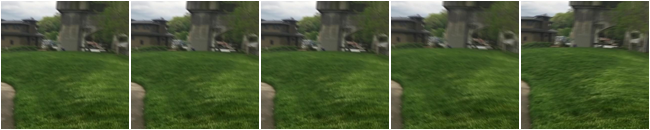

showing patchGT	


showing net output	


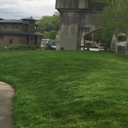

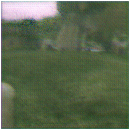

In [11]:
print('showing patchInput')
local patchInput = batchInputSample[{{1},{},{},{}}]
itorch.image(patchInput:contiguous():view(5,3,128,128))

print('showing patchGT')
-- show example output
local patchGT = batchGTSample[1]
itorch.image(patchGT)

print('showing net output')
patchInput = patchInput:float():div(max_intensity):cuda()
net:evaluate() -- set train = false
local predict = net:forward(patchInput)
predict = predict:mul(max_intensity):byte()
itorch.image(predict)
